# Analysis of best fitness values

In [20]:
import os
import pickle
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pycgp import probabilistic_mutation, point_mutation, single_mutation
from pycgp.gems import MatchByActiveStrategy, MatchSMStrategy, MatchPMStrategy

mutations = [
       # (probabilistic_mutation, MatchSMStrategy),
        (point_mutation, MatchPMStrategy),
        #(single_mutation, MatchSMStrategy),
        (single_mutation, MatchByActiveStrategy),
        (probabilistic_mutation, MatchByActiveStrategy)
]

gems = [0, 5, 10]
cols = [10, 50, 100]

def iterate_folder(folder):
    for index, ((mutation, strategy), gem, column) in enumerate(product(mutations, gems, cols)):
        file = os.path.join(folder,  f'{mutation.__name__}-{strategy.__name__}-gems{gem}-n_cols{column}.csv')
        with open (file, 'rb') as fp:
            data = pickle.load(fp)
        
        yield mutation.__name__, strategy.__name__, gem, column, data
    

In [31]:
def density_plots(folder, value_gttr):
    best = []

    for raw in iterate_folder(folder):
            m, s, g, c, data = raw
            best.append([g, m, s] + [value_gttr(x) for x in data])

    df = pd.DataFrame(best)
    df.columns = ['gems', 'mutation', 'strategy', *list(range(1,21))]

    _, axs = plt.subplots(1,3, figsize=(12,3))

    choices = [
        (point_mutation.__name__, MatchPMStrategy.__name__),
        (single_mutation.__name__, MatchByActiveStrategy.__name__),
        (probabilistic_mutation.__name__, MatchByActiveStrategy.__name__)
    ]

    titles = ['point' ,'Single mutation', 'Probabilistic mutation']
    
    ylims = [
        (0, 5), (0, 5), (0, 5)
    ]
    
    for i, (m, s) in enumerate(choices):
        avgs = []
        nonzero = []
        for g in gems:
            d = df[(df.mutation == m) & (df.strategy == s)]
            values = d.iloc[:,3:][d.gems == g].values.flatten()
            sns.kdeplot(values, ax=axs[i], label=g, shade=True)
            avgs.append(np.mean(values))
            nonzero.append(np.count_nonzero(values == 0))
            
        #axs[i].set_title('{}\n{}\n0 - {:3f}, {}\n5 - {:3f}, {}\n10 - {:3f}, {}'.format(m,s,avgs[0], nonzero[0], avgs[1], nonzero[1], avgs[2], nonzero[2]))
        axs[i].set_title(titles[i])
        axs[i].set_xlabel('Mean squared error')
        axs[i].set_ylim(ylims[i])
    print(df.groupby('gems').mean().mean(axis=1))

gems
0     0.276292
5     0.278701
10    0.268488
dtype: float64
gems
0     0.276292
5     0.291475
10    0.282212
dtype: float64
gems
0     0.276292
5     0.282394
10    0.282484
dtype: float64


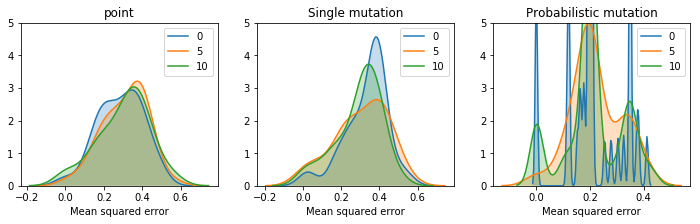

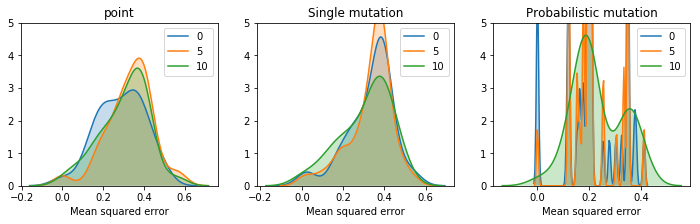

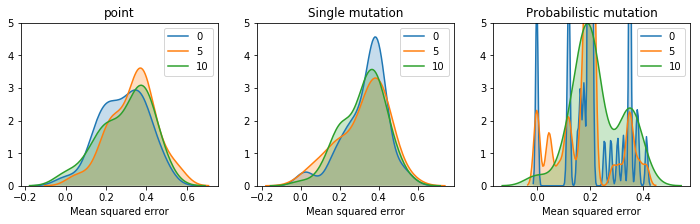

In [32]:
def best_of_run_kdes(folder):
    density_plots(folder, lambda x: x['best'].fitness)

folders = [
    'scripts/symbolic_basic/',
    'scripts/or_symbolic_basic/',
    'scripts/or_symbolic_basic_equal/'
]
for x in folders:
    best_of_run_kdes(x)

#plt.savefig('figures/sr-kdes.pdf', dpi=1000, bbox_inches='tight')
    

In [4]:
df.groupby('gems').min().mean(axis=1)

NameError: name 'df' is not defined

In [ ]:
data = []
ldata = {}

for m, s, g, c, d in iterate_folder('scripts/symbolic_basic'):
    values = [x['best'].fitness for x in d]
    stats = [g, c, np.min(values), np.mean(values), np.std(values)]
    data.append([m, s] + stats)
    ldata[f'{m}-{s}-{g}-{c}'] = stats
    
data = pd.DataFrame([*data]) 
data.columns = ['mutation', 'strategy', 'gems', 'columns', 'min', 'mean', 'std']
#data

In [ ]:
print(data.groupby('gems')['min'].mean())
print(data.groupby('gems')['mean'].mean())

In [ ]:


for k, v in ldata.items():
    row_str = '{} & {} & {:.3f} & {:.3f}\\pm {:.3f}'.format(*v)
    print(row_str)

In [ ]:
data = []

for m, s, g, c, d in iterate_folder('scripts/symbolic_basic'):
    if c != 100:
        continue
    values = [x['best'].fitness for x in d]
    data.append([m, s, g, *values])

In [ ]:
dd = pd.DataFrame(data)
dd.columns = ['m','s', 'gems', *list(range(1,21))]
dd.groupby('gems').min().iloc[:,2:].T.plot()